# Loading covid dataset


In [ ]:
import json,urllib.request
import pandas as pd

data = urllib.request.urlopen("https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/annotations/imageannotation_ai_lung_bounding_boxes.json").read()
output = json.loads(data)
filenames =  [ x['file_name'] for x in output['images']]
labels = [ x['metadata']['finding'] for x in output['images']]
view = [ x['metadata']['view'] for x in output['images']]
modality = [ x['metadata']['modality'] for x in output['images']]
#COVID pandas dataset
data = {'Finding Labels': labels, 'Image Index':filenames, 'View' : view, 'Modality': modality}
covids = pd.DataFrame.from_dict(data)
covids = covids[lambda x : x['Finding Labels'] == 'COVID-19']
covids = covids[lambda x : x['View'] == 'PA' ]
covids = covids[lambda x : x['Modality'] == "X-ray"]
#and 
covids['Image Index'] = covids['Image Index'].apply(lambda x : '/content/Images/Covid/' + x)
covids.dropna(axis=1,inplace=True)
covids.head()

,Finding Labels,Image Index,View,Modality
0,COVID-19,/content/Images/Covid/auntminnie-a-2020_01_28_...,PA,X-ray
1,COVID-19,/content/Images/Covid/auntminnie-b-2020_01_28_...,PA,X-ray
2,COVID-19,/content/Images/Covid/auntminnie-c-2020_01_28_...,PA,X-ray
3,COVID-19,/content/Images/Covid/auntminnie-d-2020_01_28_...,PA,X-ray
4,COVID-19,/content/Images/Covid/nejmc2001573_f1a.jpeg,PA,X-ray


In [ ]:
covids['Image Index'][0]

'/content/Images/Covid/auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg'

In [ ]:
%%capture
#DOWNLOAD COVID IMAGES
base_url = 'https://raw.githubusercontent.com/ieee8023/covid-chestxray-dataset/master/images/'
for filename in filenames:
  url = base_url + filename
  !wget $url -P /content/Images/Covid/

###extracting watermarks test 1

In [ ]:
!mkdir /content/Images/watermarks

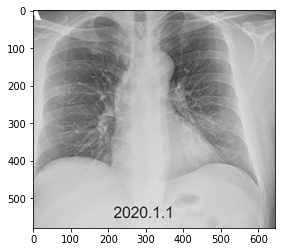

In [ ]:
from skimage.segmentation import slic
from skimage.segmentation import mark_boundaries
from skimage.util import img_as_float
import matplotlib.pyplot as plt
import numpy as np
import argparse
import cv2

path = "/content/Images/watermarks"
img = covids['Image Index'].to_numpy()
img = img[9]

img_test = np.expand_dims(plt.imread(img),0)
plt.imshow(img_test[0])

#### Extracting watermarks

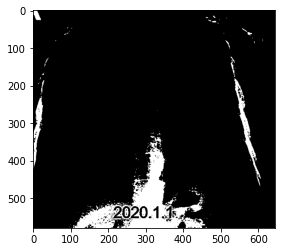

In [ ]:
cvimg = cv2.imread(img)
mask = cv2.threshold(cvimg, 210, 255, cv2.THRESH_BINARY)[1][:,:,0]
dst = cv2.inpaint(cvimg, mask, 7, cv2.INPAINT_NS)
cv2.imwrite(path + img.split('/')[-1], dst)

after = np.expand_dims(plt.imread(path + img.split('/')[-1]),0)
#plt.imshow(after[0])
plt.imshow(mask, 'gray')

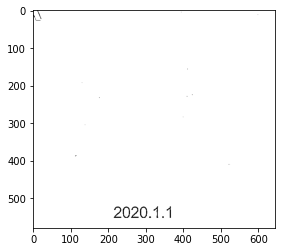

In [ ]:
#found a threshold that finds all watermarks!
cvimg = cv2.imread(img,0)
th2 = cv2.adaptiveThreshold(cvimg,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,5,19)
plt.imshow(th2, 'gray')

#Cropping Covid Images

In [ ]:
!mkdir /content/Images/Cropped/
import cv2

images = covids['Image Index'].to_numpy()
path = "/content/Images/Cropped/"

for img in images:
  cvimg = cv2.imread(img)
  xmargin = int(round(0.08*cvimg.shape[1]))
  ymargin = int(round(0.08*cvimg.shape[0]))
  crop_img = cvimg[ymargin:, xmargin:]
  cv2.imwrite(path + img.split('/')[-1], crop_img)

In [ ]:
covids['Image Index'] = covids['Image Index'].apply(lambda x : x.replace('Covid','Cropped'))

Inpaiting of white text

In [ ]:
!mkdir /content/Images/Filled

In [ ]:
images = covids['Image Index'].to_numpy()
path = "/content/Images/Filled/"

for img in images:
  cvimg = cv2.imread(img)
  mask = cv2.threshold(cvimg, 210, 255, cv2.THRESH_BINARY)[1][:,:,0]
  dst = cv2.inpaint(cvimg, mask, 7, cv2.INPAINT_NS)
  cv2.imwrite(path + img.split('/')[-1], dst)

auntminnie-a-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
auntminnie-b-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
auntminnie-c-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
auntminnie-d-2020_01_28_23_51_6665_2020_01_28_Vietnam_coronavirus.jpeg
nejmc2001573_f1a.jpeg


KeyboardInterrupt: ignored

In [ ]:
covids['Image Index'] = covids['Image Index'].apply(lambda x : x.replace('Cropped','Filled'))

# Augmentation of covid dataset



*   Flipping the image either horizontally or vertically
*   Rotating the image
*   Zooming in or out on the image
*   Varying the color on the image






In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import keras
from keras.preprocessing.image import ImageDataGenerator
%matplotlib inline


Using TensorFlow backend.


In [ ]:
# plots images with labels 
def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    cols = len(ims)//rows if len(ims) % 2 == 0 else len(ims)//rows + 1
    for i in range(len(ims)):
        sp = f.add_subplot(rows, cols, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

In [ ]:
gen = ImageDataGenerator(rotation_range=10,
                         rescale=1/255, 
                         width_shift_range=0.1, 
                         height_shift_range=0.1, 
                         shear_range=0.15, 
                         zoom_range=0.1, 
                         channel_shift_range=10., 
                         horizontal_flip=True)

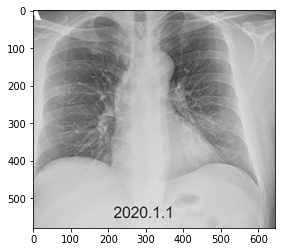

In [ ]:
img_test = np.expand_dims(plt.imread(covids['Image Index'][20]),0)
plt.imshow(img_test[0])

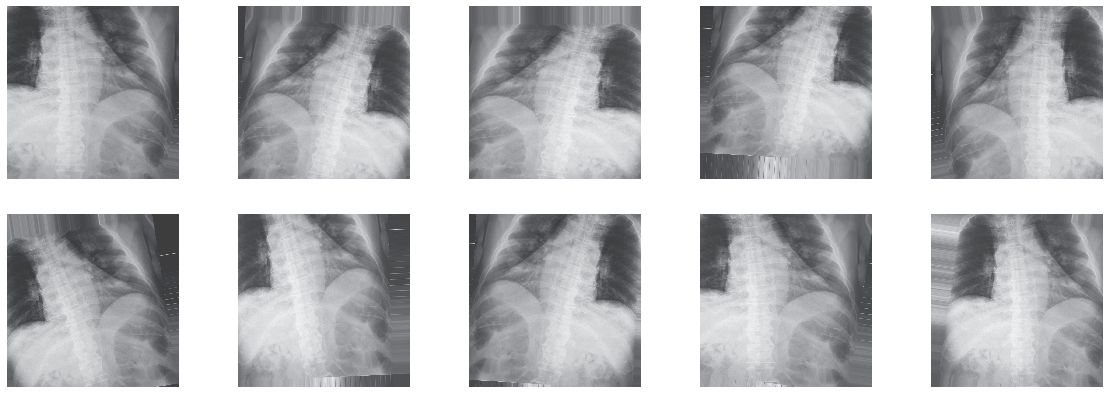

In [ ]:
aug_iter = gen.flow(img_test)
aug_images = [next(aug_iter)[0].astype(np.uint8) for i in range(10)]
plots(aug_images, figsize=(20,7), rows=2)

# Loading "No Finding" Dataset

In [ ]:
%%capture
!pip install kaggle
import json
import zipfile
import os
!mkdir /root/.kaggle
!echo '{"username":"boesingerl","key":"1f278ec8d4b16c055ed81dfc6d0c3b0f"}' > /root/.kaggle/kaggle.json
!kaggle datasets download "nih-chest-xrays/sample"
!unzip /content/sample.zip -d /content/nih

In [ ]:
all_xray_df = pd.read_csv('/content/nih/sample_labels.csv')
all_xray_df.head()

,Image Index,Finding Labels,Follow-up #,Patient ID,Patient Age,Patient Gender,View Position,OriginalImageWidth,OriginalImageHeight,OriginalImagePixelSpacing_x,OriginalImagePixelSpacing_y
0,00000013_005.png,Emphysema|Infiltration|Pleural_Thickening|Pneu...,5,13,060Y,M,AP,3056,2544,0.139,0.139
1,00000013_026.png,Cardiomegaly|Emphysema,26,13,057Y,M,AP,2500,2048,0.168,0.168
2,00000017_001.png,No Finding,1,17,077Y,M,AP,2500,2048,0.168,0.168
3,00000030_001.png,Atelectasis,1,30,079Y,M,PA,2992,2991,0.143,0.143
4,00000032_001.png,Cardiomegaly|Edema|Effusion,1,32,055Y,F,AP,2500,2048,0.168,0.168


In [ ]:
#LOAD NIH DATASET AND MERGE WITH COVID
all_xray_df = pd.read_csv('/content/nih/sample_labels.csv')
all_xray_df = all_xray_df[all_xray_df['Finding Labels'] == "No Finding"][all_xray_df['View Position'] == "PA"][['Image Index', 'Finding Labels']]
all_xray_df['Image Index'] = all_xray_df['Image Index'].apply(lambda x : '/content/nih/sample/images/' + x)
all_xray_df = all_xray_df.sample(300)
second_sample = all_xray_df[100:]
all_xray_df = all_xray_df[:100]
merged = all_xray_df.append(covids)
merged = merged.sample(frac=1).reset_index(drop=True)
print(merged)

                                           Image Index  ... Modality
0        /content/Images/Cropped/ciaa199.pdf-001-a.png  ...    X-ray
1          /content/nih/sample/images/00022309_000.png  ...      NaN
2    /content/Images/Cropped/31BA3780-2323-493F-8AE...  ...    X-ray
3          /content/nih/sample/images/00011327_001.png  ...      NaN
4          /content/nih/sample/images/00009574_030.png  ...      NaN
..                                                 ...  ...      ...
191        /content/nih/sample/images/00005421_001.png  ...      NaN
192        /content/nih/sample/images/00008343_000.png  ...      NaN
193  /content/Images/Cropped/all14238-fig-0001-m-c.jpg  ...    X-ray
194  /content/Images/Cropped/covid-19-pneumonia-28.png  ...    X-ray
195  /content/Images/Cropped/03BF7561-A9BA-4C3C-B8A...  ...    X-ray

[196 rows x 4 columns]


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:3: UserWarning: Boolean Series key will be reindexed to match DataFrame index.
  This is separate from the ipykernel package so we can avoid doing imports until


# Scale pictures and adding watermarks

### Showcase the model

#### Scaling Covid images

In [ ]:
# Scaling Covid images
gen = ImageDataGenerator()
covid_gen = gen.flow_from_dataframe(dataframe=covids,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=(224, 224),
                                     class_mode='categorical',
                                     batch_size=200)
X_covids, Y_covids = next(covid_gen)

Found 96 validated image filenames belonging to 1 classes.


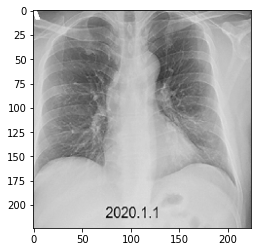

In [ ]:
ind = 62
img_scaled = X_covids[ind].astype(np.uint8)
gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
plt.imshow(gray, 'gray')

#### Filter Watermarks

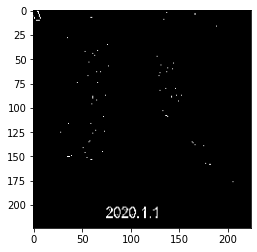

In [ ]:
th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,3,19)
th2 = cv2.bitwise_not(th2)
plt.imshow(th2, 'gray')

#### Scaling "No finding" images

In [ ]:
gen = ImageDataGenerator()
noFind_gen = gen.flow_from_dataframe(dataframe= all_xray_df,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=(224, 224),
                                     class_mode='categorical',
                                     batch_size=200)
X_batchNF, Y_batchNF = next(noFind_gen)

Found 100 validated image filenames belonging to 1 classes.


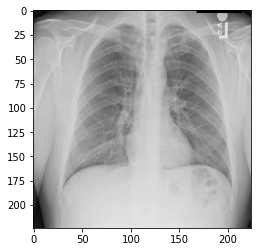

In [ ]:
imgNF_scaled = X_batchNF[ind].astype(np.uint8)
grayNF = cv2.cvtColor(imgNF_scaled, cv2.COLOR_BGR2GRAY)
plt.imshow(imgNF_scaled)

#### Combining pictures

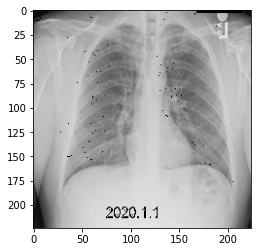

In [ ]:
contours, hierarchy = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(imgNF_scaled, contours, -1, (0,0,0), 1)
plt.imshow(imgNF_scaled, 'gray')

### Adding all watermarks from covids to No Find

In [ ]:
# Scaling Covid images
gen = ImageDataGenerator()
covid_gen = gen.flow_from_dataframe(dataframe=covids,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=(224, 224),
                                     class_mode='categorical',
                                     batch_size=200)
X_covids, Y_covids = next(covid_gen)

Found 96 validated image filenames belonging to 1 classes.


In [ ]:
noFind_gen = gen.flow_from_dataframe(dataframe= all_xray_df,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=(224, 224),
                                     class_mode='categorical',
                                     batch_size=200)
X_batchNF, Y_batchNF = next(noFind_gen)

Found 100 validated image filenames belonging to 1 classes.


In [ ]:
!mkdir /content/Images/Watermarked/

mkdir: cannot create directory ‘/content/Images/Watermarked/’: File exists


In [ ]:
path = "/content/Images/Watermarked/"
WM_Images = []
for i in range(0, len(X_covids)-1):
  #Change covid img to gray
  img_scaled = X_covids[i].astype(np.uint8)
  gray = cv2.cvtColor(img_scaled, cv2.COLOR_BGR2GRAY)
  
  #Filter Watermarks
  th2 = cv2.adaptiveThreshold(gray,255,cv2.ADAPTIVE_THRESH_MEAN_C, cv2.THRESH_BINARY,3,19)
  th2 = cv2.bitwise_not(th2)
  
  #Change No Find img to gray
  imgNF_scaled = X_batchNF[i].astype(np.uint8)
  grayNF = cv2.cvtColor(imgNF_scaled, cv2.COLOR_BGR2GRAY)
  #Combining img and watermark
  contours, hierarchy = cv2.findContours(th2, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  cv2.drawContours(imgNF_scaled, contours, -1, (0,0,0), 1)
  plt.imsave(path + str(i) +".jpeg", imgNF_scaled)
  X_batchNF[i] = imgNF_scaled
  #cv2.imwrite(path + str(i) +".jpeg", imgNF_scaled)
  WM_Images.append(path + str(i) +".jpeg")

In [ ]:
print(WM_Images)

['/content/Images/Watermarked/0.jpeg', '/content/Images/Watermarked/1.jpeg', '/content/Images/Watermarked/2.jpeg', '/content/Images/Watermarked/3.jpeg', '/content/Images/Watermarked/4.jpeg', '/content/Images/Watermarked/5.jpeg', '/content/Images/Watermarked/6.jpeg', '/content/Images/Watermarked/7.jpeg', '/content/Images/Watermarked/8.jpeg', '/content/Images/Watermarked/9.jpeg', '/content/Images/Watermarked/10.jpeg', '/content/Images/Watermarked/11.jpeg', '/content/Images/Watermarked/12.jpeg', '/content/Images/Watermarked/13.jpeg', '/content/Images/Watermarked/14.jpeg', '/content/Images/Watermarked/15.jpeg', '/content/Images/Watermarked/16.jpeg', '/content/Images/Watermarked/17.jpeg', '/content/Images/Watermarked/18.jpeg', '/content/Images/Watermarked/19.jpeg', '/content/Images/Watermarked/20.jpeg', '/content/Images/Watermarked/21.jpeg', '/content/Images/Watermarked/22.jpeg', '/content/Images/Watermarked/23.jpeg', '/content/Images/Watermarked/24.jpeg', '/content/Images/Watermarked/25.jp

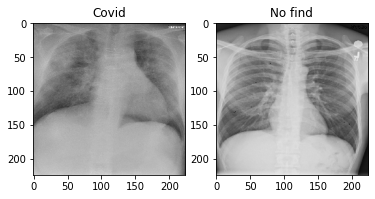

In [ ]:
index = 69 #good examples: 39 53 69
f, axarr = plt.subplots(1,2)
axarr[0].set_title('Covid')
axarr[0].imshow(X_covids[index].astype(np.uint8), 'gray')
axarr[1].set_title('No find')
axarr[1].imshow(X_batchNF[index].astype(np.uint8), 'gray')

In [ ]:
#HAS TO BE RAN AFTER THE GENERATORS

#Flow using current array and create a data generator
non_covid_gen = core_idg.flow(X_batchNF, Y_batchNF, batch_size=(X_batchNF.shape[0]))

#Get X and Y from this generator
X_non_covid, Y_non_covid = next(non_covid_gen)

#Set the Y label to be forced as non covid
Y_non_covid = np.zeros((X_non_covid.shape[0],2))
Y_non_covid[:,0] = 1

##Same for covid data
covid_gen = core_idg.flow(X_covids, Y_covids, batch_size=(X_covids.shape[0]))

#Get X and Y from this generator
X_covid, Y_covid = next(covid_gen)

#Set the Y label
Y_covid =  np.zeros((X_covid.shape[0],2))
Y_covid[:,1] = 1
#Merge them

X = np.append(X_non_covid, X_covid, axis=0)
Y = np.append(Y_non_covid, Y_covid, axis=0)
print(Y.shape)
#Randomize order
ranX = np.arange(X.shape[0])
np.random.shuffle(ranX)
ranY = np.arange(Y.shape[0])
np.random.shuffle(ranY)
X = X[ranX]
Y = Y[ranY]

(196, 2)


#### Test watermarks with Basic Model

In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense

trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

model = Sequential()
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
H = model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS)

Train on 147 samples, validate on 49 samples
Epoch 1/25
147/147 [==============================] - 0s 1ms/step - loss: 4195.9352 - categorical_accuracy: 0.4218 - val_loss: 2433.4973 - val_categorical_accuracy: 0.4898
Epoch 2/25
147/147 [==============================] - 0s 814us/step - loss: 1500.6186 - categorical_accuracy: 0.5782 - val_loss: 1437.6231 - val_categorical_accuracy: 0.3878
Epoch 3/25
147/147 [==============================] - 0s 892us/step - loss: 376.7536 - categorical_accuracy: 0.5714 - val_loss: 752.7649 - val_categorical_accuracy: 0.5102
Epoch 4/25
147/147 [==============================] - 0s 823us/step - loss: 124.7175 - categorical_accuracy: 0.6190 - val_loss: 349.3333 - val_categorical_accuracy: 0.5102
Epoch 5/25
147/147 [==============================] - 0s 829us/step - loss: 124.9777 - categorical_accuracy: 0.6190 - val_loss: 400.3250 - val_categorical_accuracy: 0.4694
Epoch 6/25
147/147 [==============================] - 0s 832us/step - loss: 2.4517 - categori

####Test Watermarks with more advanced model

In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def imagenet_model(lr=1e-3, epochs=25, dropout_rate=0.5,dense_nodes=64,base_model=VGG16):
	baseModel = base_model(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

	for layer in baseModel.layers:
		layer.trainable = False

	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(dense_nodes, activation="relu")(headModel)
	headModel = Dropout(dropout_rate)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	opt = Adam(lr=lr, decay=lr / epochs)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	return model

	model = imagenet_model(dense_nodes=50)

In [ ]:
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

H = model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=10)

Train on 147 samples, validate on 49 samples
Epoch 1/10
147/147 [==============================] - 0s 864us/step - loss: 1.6143 - categorical_accuracy: 0.5714 - val_loss: 89.9920 - val_categorical_accuracy: 0.6122
Epoch 2/10
147/147 [==============================] - 0s 844us/step - loss: 3.1505 - categorical_accuracy: 0.5850 - val_loss: 91.7592 - val_categorical_accuracy: 0.6122
Epoch 3/10
147/147 [==============================] - 0s 835us/step - loss: 1.2033 - categorical_accuracy: 0.5850 - val_loss: 88.0348 - val_categorical_accuracy: 0.6327
Epoch 4/10
147/147 [==============================] - 0s 914us/step - loss: 0.5614 - categorical_accuracy: 0.5918 - val_loss: 89.7718 - val_categorical_accuracy: 0.6122
Epoch 5/10
147/147 [==============================] - 0s 841us/step - loss: 0.5614 - categorical_accuracy: 0.5918 - val_loss: 93.4022 - val_categorical_accuracy: 0.6122
Epoch 6/10
147/147 [==============================] - 0s 824us/step - loss: 3.0529 - categorical_accuracy: 0.5

# Extracting Watermarks from covid data 2

In [ ]:
!mkdir /content/Images/Watermarked/

mkdir: cannot create directory ‘/content/Images/Watermarked/’: File exists


In [ ]:
!rm /content/Images/Watermarked/*

In [ ]:
import numpy as np
import cv2
import skimage.measure
from skimage import morphology

path = "/content/Images/Watermarked/"
WM_Images = []
masks = []
for i in range(0, len(X_covids)-1):
#for i in range(38,39):
  #Change covid img to gray
  gray = X_covids[i].astype(np.uint8)
  
  #Filter Watermarks
  mask = cv2.threshold(gray, 220, 255, cv2.THRESH_BINARY)[1]
  blur = cv2.GaussianBlur(mask,(11,11),0)
  #blur = np.where(blur > 20, 255,0)
  num_labels,labels,stats,centroids = cv2.connectedComponentsWithStats(blur, 4, cv2.CV_32S)
  for j in range(num_labels):
    if stats[j,cv2.CC_STAT_AREA] > 500 and stats[j,cv2.CC_STAT_AREA] < 30000 :
      mask = np.where(labels == j, 0, mask)

  binarized = np.where(mask > 20,1,0).astype(bool)
  processed = morphology.remove_small_objects(binarized, min_size=2, connectivity=3).astype(int)
  mask_x, mask_y = np.where(processed == 0)
  mask[mask_x,mask_y] = 0

  if(np.where(mask > 20)[0].size > 0.001*mask.size):
    cv2.imwrite(path + str(i) +".jpeg", mask)
    WM_Images.append(path + str(i) +".jpeg")
    masks.append(mask)



error: ignored

In [ ]:
path = '/content/Images/WithWatermarks/'
watermarked_images = []
!mkdir $path
for i in range(len(WM_Images)):
  rgb_mask = gray_three = cv2.merge([mask,mask,mask])
  X_batchNF[i] = np.where(rgb_mask > 20, rgb_mask, X_batchNF[i])
  cv2.imwrite(path + str(i) +".jpeg", X_batchNF[i])
  watermarked_images.append(path + str(i) + ".jpeg")

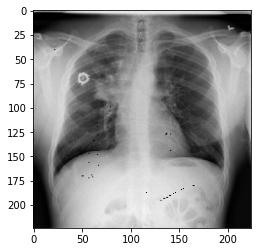

In [ ]:
import matplotlib.pyplot as plt
plt.imshow(X_batchNF[5].astype(np.uint8), 'gray')

In [ ]:
!zip -r /content/ok.zip /content/Images/Watermarked/

  adding: content/Images/Watermarked/ (stored 0%)
  adding: content/Images/Watermarked/0.jpeg (deflated 37%)
  adding: content/Images/Watermarked/58.jpeg (deflated 34%)
  adding: content/Images/Watermarked/15.jpeg (deflated 39%)
  adding: content/Images/Watermarked/59.jpeg (deflated 43%)
  adding: content/Images/Watermarked/13.jpeg (deflated 39%)
  adding: content/Images/Watermarked/16.jpeg (deflated 43%)
  adding: content/Images/Watermarked/67.jpeg (deflated 45%)
  adding: content/Images/Watermarked/55.jpeg (deflated 44%)
  adding: content/Images/Watermarked/51.jpeg (deflated 30%)
  adding: content/Images/Watermarked/7.jpeg (deflated 43%)
  adding: content/Images/Watermarked/73.jpeg (deflated 43%)
  adding: content/Images/Watermarked/11.jpeg (deflated 28%)
  adding: content/Images/Watermarked/49.jpeg (deflated 43%)
  adding: content/Images/Watermarked/64.jpeg (deflated 45%)
  adding: content/Images/Watermarked/62.jpeg (deflated 38%)
  adding: content/Images/Watermarked/34.jpeg (deflat

#### Testing with Grad Cam

In [ ]:
!mkdir /content/Images/Gradcams_WM

mkdir: cannot create directory ‘/content/Images/Gradcams_WM’: File exists


In [ ]:
import cv2
from keras import backend as K

def get_class_activation_map(model,files,outpath='/content/Images/Gradcams') :
    for imgName in files:
      img = cv2.imread(imgName)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))
      img = np.expand_dims(img,axis=0)
      
      predict = model.predict(img)
      target_class = np.argmax(predict[0])
      last_conv = model.get_layer('block5_conv3')
      grads = K.gradients(model.output[:,target_class],last_conv.output)[0]
      pooled_grads = K.mean(grads,axis=(0,1,2))
      iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
      pooled_grads_value,conv_layer_output = iterate([img])
      
      for i in range(512):
          conv_layer_output[:,:,i] *= pooled_grads_value[i]
      
      heatmap = np.mean(conv_layer_output,axis=-1)
      
      for x in range(heatmap.shape[0]):
          for y in range(heatmap.shape[1]):
              heatmap[x,y] = np.max(heatmap[x,y],0)
      heatmap = np.maximum(heatmap,0)
      heatmap /= np.max(heatmap)
      plt.imshow(heatmap)
      img_gray = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
      upsample = cv2.resize(heatmap, (224,224))
    
      output_path_gradcam =  outpath + '/'+ imgName.split('/')[-1]
      plt.imsave(output_path_gradcam,upsample * img_gray)

In [ ]:
watermarked_images

['/content/Images/WithWatermarks/0.jpeg',
 '/content/Images/WithWatermarks/1.jpeg',
 '/content/Images/WithWatermarks/2.jpeg',
 '/content/Images/WithWatermarks/3.jpeg',
 '/content/Images/WithWatermarks/4.jpeg',
 '/content/Images/WithWatermarks/5.jpeg',
 '/content/Images/WithWatermarks/6.jpeg',
 '/content/Images/WithWatermarks/7.jpeg',
 '/content/Images/WithWatermarks/8.jpeg',
 '/content/Images/WithWatermarks/9.jpeg',
 '/content/Images/WithWatermarks/10.jpeg',
 '/content/Images/WithWatermarks/11.jpeg',
 '/content/Images/WithWatermarks/12.jpeg',
 '/content/Images/WithWatermarks/13.jpeg',
 '/content/Images/WithWatermarks/14.jpeg',
 '/content/Images/WithWatermarks/15.jpeg',
 '/content/Images/WithWatermarks/16.jpeg',
 '/content/Images/WithWatermarks/17.jpeg',
 '/content/Images/WithWatermarks/18.jpeg',
 '/content/Images/WithWatermarks/19.jpeg',
 '/content/Images/WithWatermarks/20.jpeg',
 '/content/Images/WithWatermarks/21.jpeg']

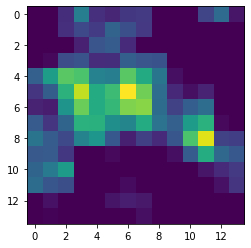

In [ ]:
get_class_activation_map(model, watermarked_images, outpath='/content/Images/Gradcams_WM/')

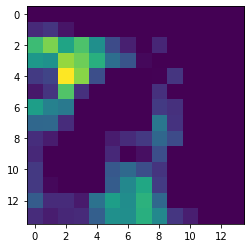

In [ ]:
get_class_activation_map(model, WM_Images, outpath='/content/Images/Gradcams_WM/')

In [ ]:
!zip -r /content/gradcams.zip /content/Images/Gradcams_WM

  adding: content/Images/Gradcams_WM/ (stored 0%)
  adding: content/Images/Gradcams_WM/0.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/15.jpeg (deflated 3%)
  adding: content/Images/Gradcams_WM/21.jpeg (deflated 5%)
  adding: content/Images/Gradcams_WM/3.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/13.jpeg (deflated 6%)
  adding: content/Images/Gradcams_WM/16.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/19.jpeg (deflated 5%)
  adding: content/Images/Gradcams_WM/9.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/1.jpeg (deflated 5%)
  adding: content/Images/Gradcams_WM/20.jpeg (deflated 3%)
  adding: content/Images/Gradcams_WM/7.jpeg (deflated 6%)
  adding: content/Images/Gradcams_WM/6.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/11.jpeg (deflated 5%)
  adding: content/Images/Gradcams_WM/18.jpeg (deflated 4%)
  adding: content/Images/Gradcams_WM/14.jpeg (deflated 3%)
  adding: content/Images/Gradcams_WM/2.jpeg (deflated 5%)
  adding: con

# Data generators

In [ ]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import os
from glob import glob
%matplotlib inline
import matplotlib.pyplot as plt

In [ ]:
INIT_LR = 1e-3
EPOCHS = 25
BS = 8

In [ ]:
from keras.preprocessing.image import ImageDataGenerator
import keras 
core_idg = ImageDataGenerator(preprocessing_function=keras.applications.vgg16.preprocess_input,
                              horizontal_flip = True, 
                              vertical_flip = False, 
                              height_shift_range= 0.1, 
                              width_shift_range=0.2, 
                              rotation_range=10, 
                              shear_range = 0.2,
                              fill_mode = 'nearest',
                              zoom_range=0.15)

In [ ]:
IMAGENET_SIZE = (224, 224)
imagenet_gen = core_idg.flow_from_dataframe(dataframe=merged,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=IMAGENET_SIZE,
                                     class_mode='categorical',
                                     batch_size=200)
noncovid_gen = core_idg.flow_from_dataframe(dataframe=second_sample,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=IMAGENET_SIZE,
                                     class_mode='categorical',
                                     classes=imagenet_gen.class_indices,
                                     batch_size=200)

Found 196 validated image filenames belonging to 2 classes.
Found 200 validated image filenames belonging to 2 classes.


# Weights initialized on NIH (TODO)
In this section, we first train a network on the NIH chest lung dataset, in order to use transfer learning with this network

## Training a network on NIH dataset (INCOMPLETE)

In [ ]:
# Start with No finding vs Pneumonia classifier using NIH dataset
nih_df = pd.read_csv('/content/nih/sample_labels.csv')
nih_df.head()

In [ ]:
data=nih_df.groupby('Finding Labels').agg('count').sort_values('Image Index',ascending=False)['Image Index']
#Select only images for which we have the most samples
finding_labels = list(data.head(5).index)
#Let's train on the first 5, for now just with the samples, later maybe with the full dataset

nih_df = nih_df[nih_df['Finding Labels'].isin(finding_labels)]
nih_df = nih_df[nih_df['View Position'] == 'PA']
nih_df['Image Index'] = nih_df['Image Index'].apply(lambda x : '/content/nih/sample/images/' + x)

#Sample
balanced_df=nih_df.groupby('Finding Labels',as_index = False,group_keys=False).apply(lambda s: s.sample(100,replace=True))

before_sampling = nih_df.groupby('Finding Labels').agg('count').sort_values('Image Index',ascending=False)['Image Index']
after_sampling = balanced_df.groupby('Finding Labels').agg('count').sort_values('Image Index',ascending=False)['Image Index']

print("BEFORE SAMPLING\n\n",before_sampling, "\n\nAFTER SAMPLING\n\n",after_sampling)

In [ ]:
from sklearn.model_selection import train_test_split
IMAGENET_SIZE = (224, 224)
nih_gen = core_idg.flow_from_dataframe(dataframe=nih_df,
                                      x_col = 'Image Index',
                                      y_col = 'Finding Labels',
                                      target_size=IMAGENET_SIZE,
                                      class_mode='categorical',
                                      batch_size=balanced_df.shape[0])
X,Y = next(nih_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

In [ ]:
from keras.applications import VGG16
from keras.layers import AveragePooling2D, Input
from keras.optimizers import Adam
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.models import Model

baseModel = VGG16(weights="imagenet", include_top=False,
	input_tensor=Input(shape=(224, 224, 3)))
headModel = baseModel.output
headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(64, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(5, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)

trainAug = ImageDataGenerator(
	rotation_range=15,
	fill_mode="nearest")

In [ ]:
INIT_LR=1e-4
opt = Adam(lr=INIT_LR, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt,metrics=["categorical_accuracy"])

H = model.fit_generator(
	trainAug.flow(trainX, trainY, batch_size=BS),
	steps_per_epoch=len(trainX) // BS,
  validation_data=(testX, testY),
	validation_steps = len(testX) //BS,
	epochs=50)

In [ ]:
from keras.metrics import categorical_accuracy
pred_Y = model.predict(testX, batch_size = 10, verbose = True)

Plotting losses

In [ ]:
# Plot training & validation accuracy values
plt.plot(H.history['categorical_accuracy'])
plt.plot(H.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

Pretty highly overfitting => need more data (use complete nih dataset and not only a sample of it)

# Training without transfer learning



In [ ]:
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Flatten, Dense

X,Y = next(imagenet_gen)
print(len(X))
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

196


In [ ]:
model = Sequential()
model.add(Flatten())
model.add(Dense(64, activation="relu"))
model.add(Dense(2, activation="softmax"))

model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['categorical_accuracy'])
H = model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS)

Train on 147 samples, validate on 49 samples
Epoch 1/25
147/147 [==============================] - 0s 1ms/step - loss: 38.3250 - categorical_accuracy: 0.4490 - val_loss: 25.4515 - val_categorical_accuracy: 0.3673
Epoch 2/25
147/147 [==============================] - 0s 590us/step - loss: 12.7150 - categorical_accuracy: 0.5034 - val_loss: 12.4090 - val_categorical_accuracy: 0.3673
Epoch 3/25
147/147 [==============================] - 0s 599us/step - loss: 7.7074 - categorical_accuracy: 0.5986 - val_loss: 6.1206 - val_categorical_accuracy: 0.7143
Epoch 4/25
147/147 [==============================] - 0s 612us/step - loss: 5.5332 - categorical_accuracy: 0.6395 - val_loss: 2.6499 - val_categorical_accuracy: 0.7551
Epoch 5/25
147/147 [==============================] - 0s 624us/step - loss: 2.8411 - categorical_accuracy: 0.7687 - val_loss: 4.1385 - val_categorical_accuracy: 0.6122
Epoch 6/25
147/147 [==============================] - 0s 600us/step - loss: 2.9288 - categorical_accuracy: 0.7687

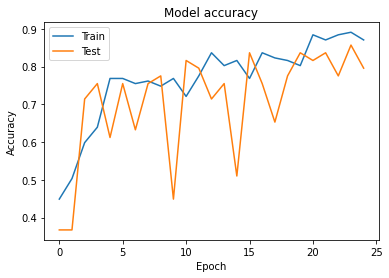

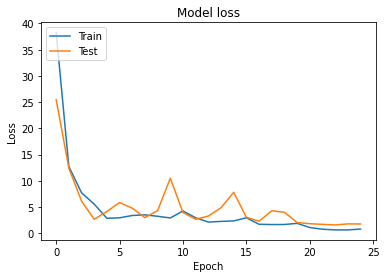

In [ ]:
# Plot training & validation accuracy values
plt.plot(H.history['categorical_accuracy'])
plt.plot(H.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
val_loss, val_acc = model.evaluate(testX, testY)
print(val_loss, val_acc)

49/49 [==============================] - 0s 674us/step
1.7443026863798803 0.795918345451355


In [ ]:
model.predict(test_x)

array([[5.51494072e-14, 1.00000000e+00],
       [3.04831160e-11, 1.00000000e+00],
       [7.06671417e-01, 2.93328553e-01],
       [5.85753052e-03, 9.94142473e-01],
       [5.94752669e-01, 4.05247390e-01],
       [2.36160975e-17, 1.00000000e+00],
       [7.39443640e-04, 9.99260604e-01],
       [3.33973655e-20, 1.00000000e+00],
       [9.99474943e-01, 5.25083626e-04],
       [8.92481644e-10, 1.00000000e+00],
       [3.91554158e-06, 9.99996066e-01],
       [9.96228695e-01, 3.77132115e-03],
       [3.23394779e-05, 9.99967694e-01],
       [1.00000000e+00, 5.08044238e-08],
       [9.80948687e-01, 1.90513618e-02],
       [9.82035608e-09, 1.00000000e+00],
       [1.63082472e-08, 1.00000000e+00],
       [1.31439232e-19, 1.00000000e+00],
       [6.43678069e-01, 3.56321961e-01],
       [9.99999881e-01, 9.18299463e-08],
       [1.00000000e+00, 4.01026545e-10],
       [9.06068027e-01, 9.39319953e-02],
       [5.77513946e-16, 1.00000000e+00],
       [2.62327015e-01, 7.37672985e-01],
       [2.940071

**This indecates that the network is overfitting**

# Weights initialized on ImageNet
In this section, we use a network pretrained on the ImageNet dataset for transfer learning.
Baseline : https://colab.research.google.com/github/HarshCasper/Brihaspati/blob/master/COVID-19/COVID19-XRay.ipynb#scrollTo=_Oc8hGXDIFDd

I would have preferred to use fit_generator rather than simple fit using a part of dataset, but it appears that grid search with sklearn is not doable otherwise

We use categorical crossentropy, as cases cannot be both covid and non-covid

In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def imagenet_model(lr=1e-3, epochs=25, dropout_rate=0.5,dense_nodes=64,base_model=VGG16):
	baseModel = base_model(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

	for layer in baseModel.layers:
		layer.trainable = False

	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(dense_nodes, activation="relu")(headModel)
	headModel = Dropout(dropout_rate)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	opt = Adam(lr=lr, decay=lr / epochs)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	return model

In [ ]:
from keras.applications.vgg16 import preprocess_input

model = imagenet_model(dense_nodes=50)
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

H = model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=25)

Train on 147 samples, validate on 49 samples
Epoch 1/25
147/147 [==============================] - 10s 66ms/step - loss: 2.6161 - categorical_accuracy: 0.4626 - val_loss: 1.2036 - val_categorical_accuracy: 0.5918
Epoch 2/25
147/147 [==============================] - 1s 8ms/step - loss: 1.5639 - categorical_accuracy: 0.5170 - val_loss: 0.5405 - val_categorical_accuracy: 0.7551
Epoch 3/25
147/147 [==============================] - 1s 8ms/step - loss: 0.9046 - categorical_accuracy: 0.6939 - val_loss: 0.4394 - val_categorical_accuracy: 0.7755
Epoch 4/25
147/147 [==============================] - 1s 8ms/step - loss: 0.8577 - categorical_accuracy: 0.7279 - val_loss: 0.4421 - val_categorical_accuracy: 0.7959
Epoch 5/25
147/147 [==============================] - 1s 8ms/step - loss: 0.5945 - categorical_accuracy: 0.7687 - val_loss: 0.4217 - val_categorical_accuracy: 0.7959
Epoch 6/25
147/147 [==============================] - 1s 8ms/step - loss: 0.3467 - categorical_accuracy: 0.8707 - val_loss:

In [ ]:
validX,validY = next(noncovid_gen)
model.evaluate(validX,validY)

200/200 [==============================] - 3s 15ms/step


[0.3320246982574463, 0.8349999785423279]

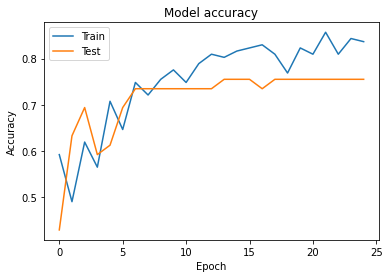

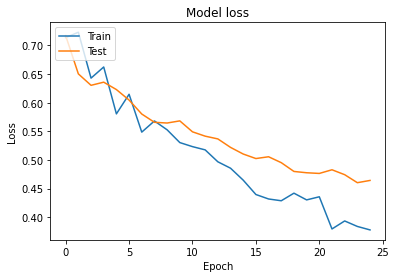

In [ ]:
# Plot training & validation accuracy values
plt.plot(H.history['categorical_accuracy'])
plt.plot(H.history['val_categorical_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

# Plot training & validation loss values
plt.plot(H.history['loss'])
plt.plot(H.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.show()

In [ ]:
loss, accuracy = model.evaluate(testX, testY)
print(loss,accuracy)

49/49 [==============================] - 0s 7ms/step
0.4642377483601473 0.7551020383834839


## Hyper-parameter optimization with sklearn

In [ ]:
from keras.wrappers.scikit_learn import KerasClassifier
from sklearn.model_selection import GridSearchCV

model = KerasClassifier(build_fn=imagenet_model)

# define the grid search parameters
epochs = [10,25,50,100]
dense_nodes = [16,32,64,128]
dropout = [0.1,0.5,0.7]
lr = [1e-5,1e-4,1e-3]

param_grid = dict(epochs=epochs)
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=2, cv=5,verbose=1, scoring = binary_accuracy,pre_dispatch=2)
grid_result = grid.fit(X, Y)


In [ ]:
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Sklearn's gridsearch has isssues with keras classifiers on multilabel classification : returns nan scoring

## Hyper-parameter optimization with keras-tuner

In [ ]:
!pip install -U keras-tuner

     |████████████████████████████████| 61kB 7.0MB/s 
  Created wheel for keras-tuner: filename=keras_tuner-1.0.1-cp36-none-any.whl size=73200 sha256=27c26836d5f32c2583e00811a27bb88d34247f22144022f0525d4307c0ddc587
  Stored in directory: /root/.cache/pip/wheels/b9/cc/62/52716b70dd90f3db12519233c3a93a5360bc672da1a10ded43
  Created wheel for terminaltables: filename=terminaltables-3.1.0-cp36-none-any.whl size=15356 sha256=a1528306720a3de1af56dc58399b5c865dada3c91c3c50506c7684fc2aab8db5
  Stored in directory: /root/.cache/pip/wheels/30/6b/50/6c75775b681fb36cdfac7f19799888ef9d8813aff9e379663e
Successfully built keras-tuner terminaltables


In [ ]:
from tensorflow import keras
from tensorflow.keras import layers
from kerastuner.tuners import RandomSearch, Hyperband
from tensorflow.keras.applications import VGG16
from tensorflow.keras import Model
from tensorflow.keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from tensorflow.keras.optimizers import Adam
from sklearn.model_selection import train_test_split

decays = [10,25,50,100]
dense_nodes = [16,32,64,128]
dropout = [0.1,0.5,0.7]
lrs = [1e-5,1e-4,1e-3]
models = [VGG16]

def tuner_model(hp):
  base_model = VGG16
  baseModel = base_model(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

  for layer in baseModel.layers:
    layer.trainable = False

  headModel = baseModel.output
  headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
  headModel = Flatten(name="flatten")(headModel)
  headModel = Dense(hp.Choice('dense_nodes', values=dense_nodes), activation="relu")(headModel)
  headModel = Dropout(hp.Choice('dropout_rate',values=dropout))(headModel)
  headModel = Dense(2, activation="softmax")(headModel)
  model = Model(inputs=baseModel.input, outputs=headModel)
  lr = hp.Choice('learning_rate',values=lrs)
  opt = Adam(lr=lr, decay=lr / hp.Choice('decay', values=decays))
  model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
  return model

In [ ]:
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

tuner = Hyperband(
    tuner_model,
    objective='val_categorical_accuracy',
    max_epochs=40,
    project_name='tuning_categorical'
    )

tuner.search_space_summary()

In [ ]:
tuner.search(trainX, trainY,epochs=25,validation_data=(testX, testY),verbose=0)
tuner.results_summary()

INFO:tensorflow:Oracle triggered exit


In [ ]:
best_model = tuner.get_best_models(num_models=1)[0]

# Evaluate the best model.
loss, accuracy = best_model.evaluate(testX, testY)

2/2 [==============================] - 0s 68ms/step - loss: 0.3679 - categorical_accuracy: 0.8980


In [ ]:
tuner.get_best_hyperparameters()[0].values

{'decay': 25,
 'dense_nodes': 64,
 'dropout_rate': 0.1,
 'learning_rate': 0.001,
 'tuner/bracket': 3,
 'tuner/epochs': 40,
 'tuner/initial_epoch': 14,
 'tuner/round': 3,
 'tuner/trial_id': 'a555f890ed24cb050b867cdbdf53d128'}

Pretty good results : 0.898 vs 0.7551 categorical accuracy

## Testing different applications (ResNet, Inception)

In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

def imagenet_model(lr=1e-3, epochs=25, dropout_rate=0.5,dense_nodes=64,base_model=VGG16):
	baseModel = base_model(weights="imagenet", include_top=False,
		input_tensor=Input(shape=(224, 224, 3)))

	for layer in baseModel.layers:
		layer.trainable = False

	headModel = baseModel.output
	headModel = AveragePooling2D(pool_size=(4, 4))(headModel)
	headModel = Flatten(name="flatten")(headModel)
	headModel = Dense(dense_nodes, activation="relu")(headModel)
	headModel = Dropout(dropout_rate)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	opt = Adam(lr=lr, decay=INIT_LR / epochs)
	model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])
	return model

Resnet : issue with overfitting

In [ ]:
from keras.applications import VGG16
from keras.applications.mobilenet_v2 import MobileNetV2
from keras.applications.inception_resnet_v2 import InceptionResNetV2
from keras.applications.vgg19 import VGG19
from keras.applications.resnet import ResNet50, ResNet101
models = [ResNet50, ResNet101]
histories = []
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)
for mod in models:
	#different model
	model = imagenet_model(base_model=mod)
	#train
	H = model.fit(
		trainX, trainY,
		validation_data=(testX, testY),
		epochs=EPOCHS,
		verbose=0)
	histories.append(H)

In [ ]:
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

In [ ]:
from keras.layers import GlobalAveragePooling2D
import tensorflow.keras.backend as K

baseModel = ResNet50(weights="imagenet", include_top=False,
input_tensor=Input(shape=(224, 224, 3)),layers=tf.keras.layers)

for layer in model.layers:
    if hasattr(layer, 'moving_mean') and hasattr(layer, 'moving_variance'):
        layer.trainable = True
        K.eval(K.update(layer.moving_mean, K.zeros_like(layer.moving_mean)))
        K.eval(K.update(layer.moving_variance, K.ones_like(layer.moving_variance)))
    else:
        layer.trainable = False

headModel = baseModel.output
headModel = AveragePooling2D()(headModel)
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
opt = Adam(lr=1e-5, decay=INIT_LR / EPOCHS)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

train_datagen = ImageDataGenerator(preprocessing_function=keras.applications.resnet50.preprocess_input)

H = model.fit_generator(
		train_datagen.flow(trainX, trainY, batch_size=BS),
		validation_data=(testX, testY),
		epochs=EPOCHS)

In [ ]:
print([x.history['val_accuracy'][-1] for x in histories])

## Different types of transfer learning (keeping some fully connected layers) and comparison (TODO : GRADCAM ON THESE)
Everything done on the VGG16 : our baseline model

In [ ]:
vgg = VGG16(weights="imagenet", include_top=False,	input_tensor=Input(shape=(224, 224, 3)))
[x.name for x in vgg.layers]

58892288/58889256 [==============================] - 3s 0us/step


['input_6',
 'block1_conv1',
 'block1_conv2',
 'block1_pool',
 'block2_conv1',
 'block2_conv2',
 'block2_pool',
 'block3_conv1',
 'block3_conv2',
 'block3_conv3',
 'block3_pool',
 'block4_conv1',
 'block4_conv2',
 'block4_conv3',
 'block4_pool',
 'block5_conv1',
 'block5_conv2',
 'block5_conv3',
 'block5_pool']

In [ ]:
from keras.applications import VGG16
from sklearn.model_selection import train_test_split
vgg = VGG16(weights="imagenet", include_top=True,	input_tensor=Input(shape=(224, 224, 3)))



[x.name for x in vgg.layers]

NameError: ignored

### Keeping some fully connected layers without training them

In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
models = []
baseModel = VGG16(weights="imagenet", include_top=True,	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
	layer.trainable = False

for i in np.arange(4)+1:
	headModel = baseModel.layers[-i].output
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	opt = Adam(lr=1e-3, decay=INIT_LR / EPOCHS)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	models.append(model)


In [ ]:
losses, accs = [], []
for model in models:	
	model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS, verbose=0)
	loss, acc = model.evaluate(testX,testY)
	losses.append(loss)
	accs.append(acc)
accs

49/49 [==============================] - 1s 11ms/step


[0.5306122303009033, 0.7346938848495483, 0.7755101919174194, 0.918367326259613]

Text(0.5, 0, 'Number of fully connected layers kept')

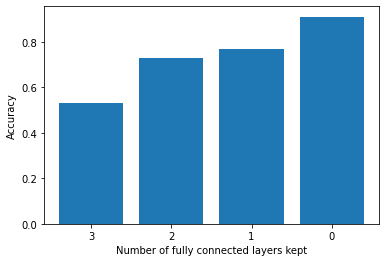

In [ ]:
plt.bar(['3','2', '1', '0'],[0.53,0.73,0.77,0.91])
plt.ylabel('Accuracy')
plt.xlabel('Number of fully connected layers kept')

### Keeping some fully connected layers and training them

In [ ]:
from keras.applications import VGG16
from keras import activations
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
models = []
baseModel = VGG16(weights="imagenet", include_top=True,	input_tensor=Input(shape=(224, 224, 3)))
for layer in baseModel.layers:
	layer.trainable = False
baseModel.layers[-1].activation = activations.relu
for j in range(1,5):
	baseModel.layers[-j].trainable = True


for i in range(1,5):
	opt = Adam(lr=1e-3, decay=INIT_LR / EPOCHS)
	baseModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	headModel = baseModel.layers[-i].output
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	models.append(model)
	


In [ ]:
import keras.backend as K
K.clear_session()

In [ ]:
from sklearn.model_selection import train_test_split
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

losses, accs = [], []
for model in models:	
	model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS, verbose=0)
	loss, acc = model.evaluate(testX,testY)
	losses.append(loss)
	accs.append(acc)
accs

49/49 [==============================] - 0s 5ms/step


[0.5510203838348389,
 0.9387755393981934,
 0.9591836929321289,
 0.9591836929321289]

Text(0.5, 0, 'Number of fully connected layers kept')

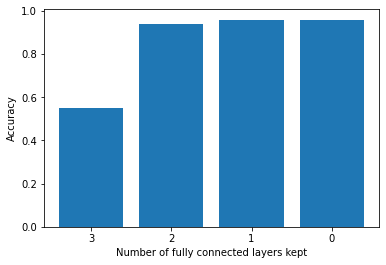

In [ ]:
plt.bar(['3','2', '1', '0'],accs)
plt.ylabel('Accuracy')
plt.xlabel('Number of fully connected layers kept')

### Discarding fully connected layers and training some convolutional layers

In [ ]:
from keras.applications import VGG16
from keras import activations
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
models = []
layers = ['block5','block4','block3','block2','block1']

for i in range(len(layers)):
	baseModel = VGG16(weights="imagenet", include_top=False,	input_tensor=Input(shape=(224, 224, 3)))
	for layer in baseModel.layers:
		if(layer.name in layers[:i+1]):
			layer.trainable = True
		else:
			layer.trainable = False
	opt = Adam(lr=1e-3, decay=INIT_LR / EPOCHS)
	baseModel.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	headModel = baseModel.output
	headModel = Flatten()(headModel)
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	models.append(model)
	


In [ ]:
from sklearn.model_selection import train_test_split
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)

losses, accs = [], []
for model in models:	
	model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS, verbose=0)
	loss, acc = model.evaluate(testX,testY)
	losses.append(loss)
	accs.append(acc)
accs

KeyboardInterrupt: ignored

Text(0.5, 0, 'Number of fully connected layers kept')

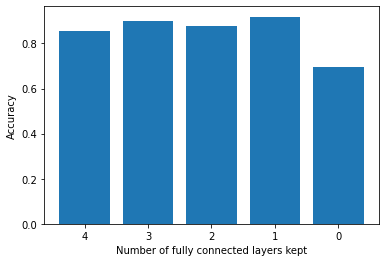

In [ ]:
labels = [str(x) for x in range(1,6)]
plt.bar(labels,accs)
plt.ylabel('Accuracy')
plt.xlabel('Number of trainable convolutional layers')

## Verifying accuracy of cropping and filling up blanks in images

In [ ]:
covids['Image Index'] = covids['Image Index'].apply(lambda x : x.replace('Covid','Filled'))

filled = all_xray_df.append(covids)
filled = filled.sample(frac=1).reset_index(drop=True)

covids['Image Index'] = covids['Image Index'].apply(lambda x : x.replace('Filled','Cropped'))

cropped = all_xray_df.append(covids)
cropped = cropped.sample(frac=1).reset_index(drop=True)

covids['Image Index'] = covids['Image Index'].apply(lambda x : x.replace('Cropped','Covid'))

noncropped = all_xray_df.append(covids)
noncropped = noncropped.sample(frac=1).reset_index(drop=True)

,Image Index,Finding Labels,View,Modality
0,/content/nih/sample/images/00016300_001.png,No Finding,NaN,NaN
1,/content/nih/sample/images/00017325_000.png,No Finding,NaN,NaN
2,/content/nih/sample/images/00028770_000.png,No Finding,NaN,NaN
3,/content/Images/Filled/covid-19-pneumonia-12.jpg,COVID-19,PA,X-ray
4,/content/Images/Filled/9C34AF49-E589-44D5-92D3...,COVID-19,PA,X-ray


In [ ]:
IMAGENET_SIZE = (224, 224)
filled_gen = core_idg.flow_from_dataframe(dataframe=filled,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=IMAGENET_SIZE,
                                     class_mode='categorical',
                                     batch_size=200)

cropped_gen = core_idg.flow_from_dataframe(dataframe=cropped,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=IMAGENET_SIZE,
                                     class_mode='categorical',
                                     batch_size=200)
noncropped_gen = core_idg.flow_from_dataframe(dataframe=noncropped,
                                     x_col = 'Image Index',
                                     y_col = 'Finding Labels',
                                     target_size=IMAGENET_SIZE,
                                     class_mode='categorical',
                                     batch_size=200)
 

Found 196 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.
Found 196 validated image filenames belonging to 2 classes.


In [ ]:
from keras.applications import VGG16
from keras import Model
from keras.layers import AveragePooling2D, Input, Flatten, Dense, Dropout
from keras.optimizers import Adam
from sklearn.model_selection import train_test_split

losses,accs=[],[]

for gen in [filled_gen,cropped_gen,noncropped_gen]:
	X,Y = next(gen)
	trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)
	baseModel = VGG16(weights="imagenet", include_top=True,	input_tensor=Input(shape=(224, 224, 3)))

	for layer in baseModel.layers:
		layer.trainable = False

	headModel = baseModel.layers[-4].output
	headModel = Dropout(0.5)(headModel)
	headModel = Dense(2, activation="softmax")(headModel)
	model = Model(inputs=baseModel.input, outputs=headModel)
	opt = Adam(lr=1e-3, decay=INIT_LR / EPOCHS)
	model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])
	model.fit(
	trainX, trainY,
  validation_data=(testX, testY),
	epochs=EPOCHS, verbose=0)
	loss, acc = model.evaluate(testX,testY)
	losses.append(loss)
	accs.append(acc)

49/49 [==============================] - 0s 3ms/step


In [ ]:
print(losses,accs)

[0.37873092841128914, 0.3742855239887627, 0.3866433537736231] [0.8979591727256775, 0.8367347121238708, 0.7755101919174194]


Text(0, 0.5, 'Validation aaccuracy')

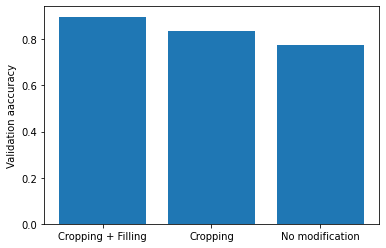

In [ ]:
plt.bar(['Cropping + Filling', 'Cropping', 'No modification'],accs)
plt.ylabel('Validation accuracy')

Using a noncovid only validation set

In [ ]:
X,Y = next(imagenet_gen)
trainX, testX, trainY, testY = train_test_split(X, Y, test_size=0.25)
baseModel = VGG16(weights="imagenet", include_top=True,	input_tensor=Input(shape=(224, 224, 3)))

for layer in baseModel.layers:
  layer.trainable = False

headModel = baseModel.layers[-4].output
headModel = Dropout(0.5)(headModel)
headModel = Dense(2, activation="softmax")(headModel)
model = Model(inputs=baseModel.input, outputs=headModel)
opt = Adam(lr=1e-3, decay=INIT_LR / EPOCHS)
model.compile(loss="categorical_crossentropy", optimizer=opt, metrics=["categorical_accuracy"])

model.fit(
trainX, trainY,
validation_data=(testX, testY),
epochs=EPOCHS, verbose=0)

testx,testy = next(noncovid_gen)
loss, acc = model.evaluate(testX,testY)
print(loss,acc)

49/49 [==============================] - 0s 3ms/step
0.20201206937128183 0.9387755393981934


# Validating Results using Grad-CAM

In [ ]:
!mkdir /content/Images/Gradcams

import cv2
from keras import backend as K

def get_class_activation_map(model,files,outpath='/content/Images/Gradcams') :
    for imgName in files:
      img = cv2.imread(imgName)
      img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
      img = cv2.resize(img, (224, 224))
      img = np.expand_dims(img,axis=0)
      
      predict = model.predict(img)
      target_class = np.argmax(predict[0])
      last_conv = model.get_layer('block5_conv3')
      grads = K.gradients(model.output[:,target_class],last_conv.output)[0]
      pooled_grads = K.mean(grads,axis=(0,1,2))
      iterate = K.function([model.input],[pooled_grads,last_conv.output[0]])
      pooled_grads_value,conv_layer_output = iterate([img])
      
      for i in range(512):
          conv_layer_output[:,:,i] *= pooled_grads_value[i]
      
      heatmap = np.mean(conv_layer_output,axis=-1)
      
      for x in range(heatmap.shape[0]):
          for y in range(heatmap.shape[1]):
              heatmap[x,y] = np.max(heatmap[x,y],0)
      heatmap = np.maximum(heatmap,0)
      heatmap /= np.max(heatmap)
      plt.imshow(heatmap)
      img_gray = cv2.cvtColor(img[0], cv2.COLOR_BGR2GRAY)
      upsample = cv2.resize(heatmap, (224,224))
    
      output_path_gradcam =  outpath + '/'+ imgName.split('/')[-1]
      plt.imsave(output_path_gradcam,upsample * img_gray)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:31: RuntimeWarning: invalid value encountered in true_divide
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:452: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:459: UserWarning: Warning: converting a masked element to nan.
  a_min = np.float64(newmin)
/usr/local/lib/python3.6/dist-packages/matplotlib/image.py:464: UserWarning: Warning: converting a masked element to nan.
  a_max = np.float64(newmax)
<string>:6: UserWarning: Warning: converting a masked element to nan.
/usr/local/lib/python3.6/dist-packages/numpy/core/_asarray.py:85: UserWarning: Warning: converting a masked element to nan.
  return array(a, dtype, copy=False, order=order)


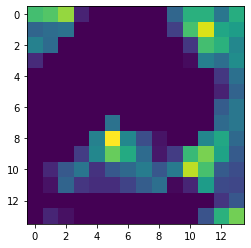

In [ ]:
test = covids['Image Index'].to_numpy()
get_class_activation_map(model,test)

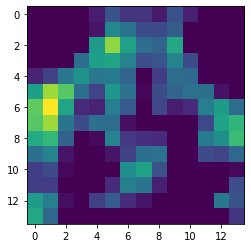

In [ ]:
!mkdir /content/Images/noncovidcams
test = all_xray_df['Image Index'].to_numpy()
get_class_activation_map(model,test,outpath='/content/Images/noncovidcams' )

In [ ]:
!zip -r /content/noncovid.zip /content/Images/noncovidcams

  adding: content/Images/noncovidcams/ (stored 0%)
  adding: content/Images/noncovidcams/00019408_000.png (stored 0%)
  adding: content/Images/noncovidcams/00025729_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00027036_001.png (deflated 0%)
  adding: content/Images/noncovidcams/00024674_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00005815_005.png (deflated 0%)
  adding: content/Images/noncovidcams/00023632_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00004415_000.png (deflated 1%)
  adding: content/Images/noncovidcams/00025442_001.png (deflated 0%)
  adding: content/Images/noncovidcams/00029820_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00023216_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00002816_001.png (deflated 0%)
  adding: content/Images/noncovidcams/00009566_000.png (deflated 0%)
  adding: content/Images/noncovidcams/00015616_001.png (deflated 0%)
  adding: content/Images/noncovidcams/00006011_003.png